<a href="https://colab.research.google.com/github/AmarnadhReddy055/Multi-Model-Hate-Speech-Detection-In-Memes/blob/main/VisualBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.0 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
from transformers import TFBertModel, BertTokenizer
import pandas as pd
import numpy as np

In [4]:
train_data=pd.read_csv('/content/drive/MyDrive/train_image.csv')
dev_data=pd.read_csv('/content/drive/MyDrive/cross_validation_image.csv')

In [5]:
train_data.dropna(inplace=True)
train_data.reset_index(inplace=True)

In [6]:
def covert_string_toarray_train(train_object):
  size_train=train_object.shape[0]
  print(size_train)
  for i in range(size_train):
    train_data['features'][i]=np.fromstring(train_data['features'][i][1:-1], sep=',')

In [7]:
covert_string_toarray_train(train_data['features'])

8499


<ipython-input-6-8996c8233cd4>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['features'][i]=np.fromstring(train_data['features'][i][1:-1], sep=',')


In [8]:
train_image=[]
for i in range(train_data.shape[0]):
  train_image.append(np.array(train_data['features'][i]))
train_image=np.array(train_image)

In [9]:
visualbert_model = TFBertModel.from_pretrained('uclanlp/visualbert-vqa-coco-pre', from_pt=True)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

You are using a model of type visual_bert to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['visual_bert.encoder.layer.11.attention.self.value.bias', 'visual_bert.encoder.layer.5.attention.self.query.weight', 'visual_bert.encoder.layer.0.attention.self.value.weight', 'visual_bert.embeddings.visual_projection.bias', 'visual_bert.encoder.layer.5.attention.self.value.bias', 'visual_bert.encoder.layer.7.attention.self.value.bias', 'visual_bert.encoder.layer.7.output.dense.bias', 'visual_bert.encoder.layer.8.attention.self.key.weight', 'visual_bert.encoder.layer.2.attention.self.key.bias', 'visual_bert.embeddings.visual_projection.weight', 'visual_bert.encoder.layer.6.attention.output.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.bias', 'visual_bert.encoder.layer.6.output.dense.bias', 'visual_bert.pooler.dense.bias', 'visual_bert.encoder.layer.11.intermediate.dense.weight', 'visual_bert.encoder.layer.8.output.dense.weight', 'visual_bert.encoder.layer.7.attention.self.value.weig

In [10]:
train_text=list(train_data['text'])

In [11]:
text_input_ids = tf.keras.Input(shape=(88,), dtype=tf.int32, name='input_ids')
text_attention_mask = tf.keras.Input(shape=(88,), dtype=tf.int32, name='attention_mask')
image_input = tf.keras.Input(shape=(2048,), dtype=tf.float32, name='image_input')

In [12]:
text_tokens = tokenizer(train_text, padding=True, truncation=True, return_tensors='tf')
text_encodings = {'input_ids': text_tokens['input_ids'], 'attention_mask': text_tokens['attention_mask']}

In [13]:
train_text_ids = text_encodings

In [14]:
input_sequence = {'input_ids': text_encodings['input_ids'],
                  'attention_mask': text_encodings['attention_mask'],
                  'image': train_image}

In [15]:
train_labels = train_data['label']

In [16]:
from tensorflow import keras
from transformers import TFAutoModel

In [17]:
def covert_string_toarray_dev(dev_object):
  size_dev=dev_object.shape[0]
  print(size_dev)
  for i in range(size_dev):
    dev_data['features'][i]=np.fromstring(dev_data['features'][i][1:-1], sep=',')

In [18]:
covert_string_toarray_dev(dev_data['features'])

500


<ipython-input-17-fb9ef8d8594c>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dev_data['features'][i]=np.fromstring(dev_data['features'][i][1:-1], sep=',')


In [19]:
dev_image=[]
for i in range(dev_data.shape[0]):
  dev_image.append(np.array(dev_data['features'][i]))
dev_image=np.array(dev_image)

In [20]:
dev_text=list(dev_data['text'])

In [21]:
test_text_tokens = tokenizer(dev_text, padding=True, truncation=True, return_tensors='tf')
test_text_encodings = {'input_ids': test_text_tokens['input_ids'], 'attention_mask': test_text_tokens['attention_mask']}

In [22]:
dev_text_ids = test_text_encodings

In [23]:
dev_labels = dev_data['label']

In [24]:
class VisualBERTClassifier(keras.layers.Layer):
    def __init__(self, num_classes, dropout_prob=0.1, l2_reg=12):
        super(VisualBERTClassifier, self).__init__()

        self.num_classes = num_classes
        self.dropout_prob = dropout_prob
        self.visualbert_model = TFAutoModel.from_pretrained('bert-base-uncased')
        self.pooling_layer = keras.layers.GlobalAveragePooling1D()
        self.dropout_layer = keras.layers.Dropout(rate=self.dropout_prob)
        self.classification_layer = keras.layers.Dense(units=self.num_classes, activation='sigmoid',kernel_regularizer=tf.keras.regularizers.l2(l2_reg))

    def call(self, inputs, **kwargs):
        text_inputs = {'input_ids': inputs['text_input']['input_ids'], 'attention_mask': inputs['text_input']['attention_mask']}
        image_inputs = inputs['image_input']
        visualbert_output = self.visualbert_model([text_inputs, image_inputs], **kwargs)
        pooled_output = self.pooling_layer(visualbert_output.last_hidden_state)
        pooled_output = self.dropout_layer(pooled_output, training=kwargs.get('training', False))
        logits = self.classification_layer(pooled_output)
        return logits

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'num_classes': self.num_classes,
            'dropout_prob': self.dropout_prob,
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(**config)

In [25]:
model = keras.models.Sequential([VisualBERTClassifier(num_classes=1, dropout_prob=0.2),])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [26]:
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.metrics import binary_crossentropy

In [27]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=[keras.metrics.BinaryAccuracy(name='accuracy')])
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

In [28]:
history = model.fit({'text_input': train_text_ids, 'image_input': train_image},
                    train_labels,
                    batch_size=32,
                    epochs=100,
                    validation_data=({'text_input': dev_text_ids, 'image_input': dev_image}, dev_labels),
                    callbacks=[early_stopping])

Epoch 1/100


266/266 [==============================] - ETA: 0s - loss: 22.6406 - accuracy: 0.6998

266/266 [==============================] - 213s 602ms/step - loss: 22.6406 - accuracy: 0.6998 - val_loss: 21.8946 - val_accuracy: 0.5460
Epoch 2/100
266/266 [==============================] - 154s 579ms/step - loss: 20.6392 - accuracy: 0.7488 - val_loss: 19.9886 - val_accuracy: 0.5620
Epoch 3/100
266/266 [==============================] - 153s 577ms/step - loss: 18.8169 - accuracy: 0.7669 - val_loss: 18.3354 - val_accuracy: 0.5660
Epoch 4/100
266/266 [==============================] - 153s 575ms/step - loss: 17.1359 - accuracy: 0.7882 - val_loss: 16.8589 - val_accuracy: 0.5300
Epoch 5/100
266/266 [==============================] - 153s 575ms/step - loss: 15.5850 - accuracy: 0.8096 - val_loss: 15.4984 - val_accuracy: 0.5440
Epoch 6/100
266/266 [==============================] - 153s 576ms/step - loss: 14.1601 - accuracy: 0.8174 - val_loss: 14.1045 - val_accuracy: 0.5500
Epoch 7/100
266/266 [==============================] - 153s 574ms/step - loss: 12.8445 - accuracy: 0.8250 - val_loss: 

In [29]:
model.evaluate({'text_input': dev_text_ids, 'image_input': dev_image}, dev_labels)

16/16 [==============================] - 2s 123ms/step - loss: 0.9997 - accuracy: 0.5220


[0.9996974468231201, 0.5220000147819519]

In [30]:
y_predicted=model.predict({'text_input': dev_text_ids, 'image_input': dev_image}).round()

16/16 [==============================] - 5s 120ms/step


In [31]:
from sklearn.metrics import classification_report
print(classification_report(dev_labels,y_predicted))

              precision    recall  f1-score   support

           0       0.51      0.86      0.64       250
           1       0.57      0.19      0.28       250

    accuracy                           0.52       500
   macro avg       0.54      0.52      0.46       500
weighted avg       0.54      0.52      0.46       500



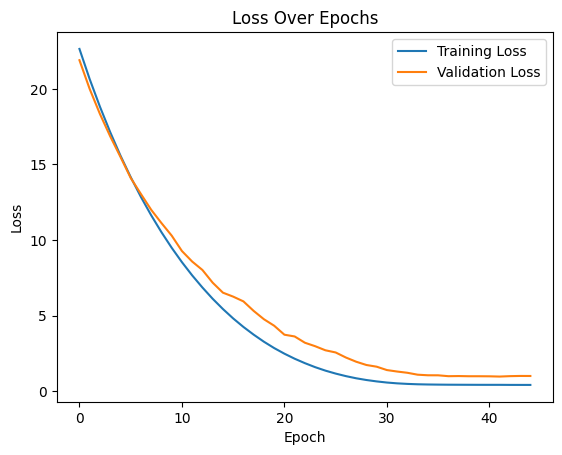

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()